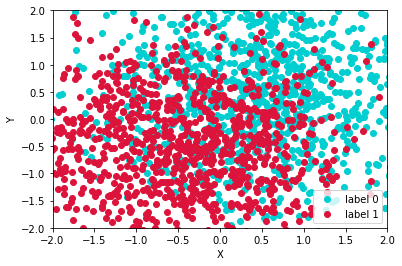

In [272]:
import scipy.stats as stats
import numpy as np 

from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
import time

n_label0 = 1000
n_label1 = 1000
mean_0 = np.ones(2)*0.5
mean_1 = np.ones(2) * -0.5

cov_0 = [1,1]
cov_1 = [1,1]
res0 = multivariate_normal.rvs(mean=mean_0,cov=cov_0,size=n_label0)
res1 = multivariate_normal.rvs(mean=mean_1,cov=cov_1,size=n_label1)

X0 = np.array(res0)
X1 = np.array(res1)
label0 = np.zeros(shape=(len(res0),1))
label1 = np.ones(shape=(len(res1),1))

X_train = np.concatenate([X0,X1],0)
Y_train = np.concatenate([label0,label1],0)
colors1 = '#00CED1' 
colors2 = '#DC143C'

plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(xmax=2,xmin=-2)
plt.ylim(ymax=2,ymin=-2)
plt.scatter(X0[:,0],X0[:,1],c=colors1,label='label 0')
plt.scatter(X1[:,0],X1[:,1],c=colors2,label='label 1')
plt.legend()
plt.show()

## 15.(a) le classifieur Bayesien

1. On propose la fonction de regression $\eta(x)$ basée sur deux distributions gaussiennes
sous-jacentes (−1/2, . . . ,−1/2) et (1/2, . . . ,1/2)
$$ \eta(x) = P(Y=1|X =x) = \frac{p_{1}(x)}{p_{0}(x)+p_{1}(x)} $$


$$=\frac{\pi_{1} \mathrm{e}^{-\left(x-\mu_{1}\right)^{T} \Sigma_{1}^{-1}\left(x-\mu_{1}\right) / 2}}{\pi_{1} \mathrm{e}^{-\left(x-\mu_{1}\right)^{T} \Sigma_{1}^{-1}\left(x-\mu_{1}\right) / 2}+\pi_{0}\left(\operatorname{det} \Sigma_{1} / \operatorname{det} \Sigma_{0}\right)^{1 / 2} \mathrm{e}^{-\left(x-\mu_{0}\right)^{T} \Sigma_{0}^{-1}\left(x-\mu_{0}\right) / 2}}$$

dans notre cas, $$\Sigma_{1} = \Sigma_{0} = \Sigma = I_{d}$$
et $$ \mu_{0} = (1/2,1/2,,,1/2), \mu_{1} = (-1/2,-1/2,,,-1/2)$$

Finalement, classifieur Bayesien $G(x) = \mathbb{1}_{\{\eta(x)>\frac{1}{2}\}}$

In [273]:

class Bayesien():
    def __init__(self,n_label0,n_label1,mean_0,mean_1):
        self.p_label_0 = n_label0/(n_label0 + n_label1)
        self.p_label_1 = n_label1/(n_label0 + n_label1)
        self.mean_0 = mean_0
        self.mean_1 = mean_1
        

    def predict(self,x):
        labels = np.ones(len(x))
        prob = (self.p_label_1 * np.exp(-0.5 * np.sum(np.square(x-self.mean_1),axis=1)))/(self.p_label_0 * np.exp(-0.5 * np.sum(np.square(x-self.mean_0),axis=1)) + self.p_label_1 *np.exp(-0.5 * np.sum(np.square(x-self.mean_1),axis=1)))
        for i in range(len(x)):
            labels[i] = 1 if prob[i] >= 0.5 else 0
        return labels



bayes = Bayesien(n_label0,n_label1,mean_0,mean_1)

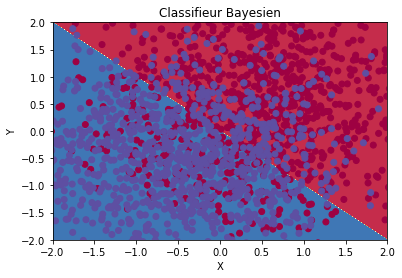

In [274]:
x_min,x_max = X_train[:,0].min()-0.5 ,X_train[:,0].max() + 0.5
y_min,y_max = X_train[:,1].min()-0.5 ,X_train[:,1].max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = bayes.predict(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)

plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(xmax=2,xmin=-2)
plt.ylim(ymax=2,ymin=-2)
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Spectral)
plt.title("Classifieur Bayesien")
plt.show()

## 15.(b) K-NN
1. On choist $Kn = \log (n)^{\frac{d}{d+2}} n^{\frac{2}{d+2}}$ selon la question 14
2. La function de régression $\eta_{n, k}(x)=\frac{1}{k} \sum_{i=1}^{k} Y_{(i)}(x)$
3. le classifieur Knn est $ \Phi_{n, k} = \mathbb{1}_{\eta(x)>\frac{1}{2}}$

On voit la figure de resultat de classifieur KNN, la zone de décision $\eta_{n,k}(x) = \frac{1}{2}$ est aussi bon que celle de classifieur bayésien, donc on dit que l'algorithme de K plus proches voisin est efficace.

## 15.(c）
on va expliquer la degradation de la vitesse lorsque la dimension augmente.
Methode de Knn a besoin de beaucoup de calcul, parce que il faut utiliser l'algo de trie pour la distance donc au mois O(nlog(n))
et pour predire m data, il faut O(mnlog(n))

In [275]:
class KNN():
    def __init__(self,label = 2):
        
        self.num_label = label

    def train(self,X,y):
        self.X_train = X
        self.y_train = y
        self.n ,self.dim= X.shape
        self.K = int(np.power(np.log(self.n),self.dim/(self.dim+2))*np.power(self.n,2/(self.dim+2)))

    def predict(self,X):
        labels = np.ones(len(X))
        for i in range(len(X)):
            labels[i] = self.get_label(X[i])

        return labels
    def get_label(self,x):
        x_neighbors = self.get_neighbor(x)
        neighbor_label = self.y_train[x_neighbors]
        neighbor_label = list(neighbor_label)
        res = neighbor_label[0]
        res_fre = neighbor_label.count(res)
        for label in neighbor_label:
            fre = neighbor_label.count(label)
            if(fre>res_fre):
                res = label
                res_fre = fre
            
        return res

        
    def get_neighbor(self,x):
        
        dis = list(map(lambda a: self.distance(a,x),self.X_train))
        pairs = sorted(zip(dis,np.arange(len(dis))),key = lambda x:x[0])[:self.K]
        neighbor_index = [p[1] for p in pairs]
        return neighbor_index
        
    
    def distance(self,x,a):
        return np.sqrt(np.sum(np.square(a-x)))




knn = KNN()
knn.train(X_train,Y_train)


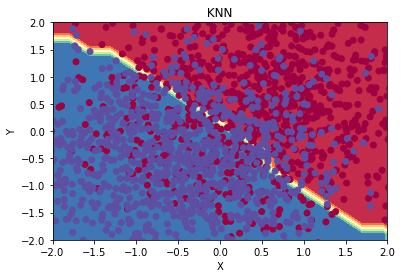

In [276]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.25), np.arange(y_min, y_max, 0.25))
Z = knn.predict(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)

plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(xmax=2,xmin=-2)
plt.ylim(ymax=2,ymin=-2)
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Spectral)
plt.title(" KNN ")
plt.show()

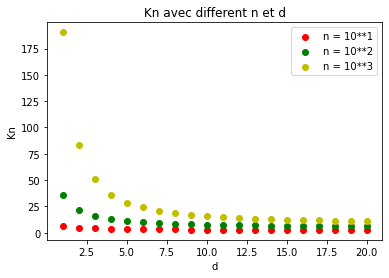

No handles with labels found to put in legend.


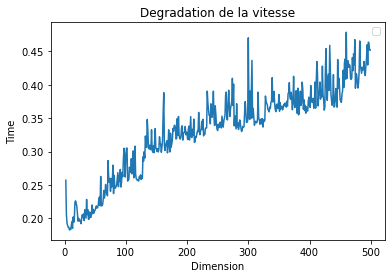

In [277]:
n = 10**3

def kn(n,d):
    i = d/(d+2)
    j = 1 - i
    return np.power(np.log(n),i)*np.power(n,j)

ds = np.arange(1,21,1)
res = kn(n,ds)
c = ['r','g','y']
for i in range(1,4):
    n = 10**i
    res = kn(n,ds)
    plt.scatter(ds,res,c=c[i-1],label='n = 10**{}'.format(i))
plt.title("Kn avec different n et d")
plt.xlabel('d')
plt.ylabel('Kn')
plt.legend()
plt.show()

ds = np.arange(2,500)
vitesse = np.ones(len(ds))

def vitesse_test(dim):
    n_label0 = 500
    n_label1 = 500
    mean_0 = np.ones(dim)*0.5
    mean_1 = np.ones(dim) * -0.5
    cov_0 = np.ones(dim)
    cov_1 = np.ones(dim)
    res0 = multivariate_normal.rvs(mean=mean_0,cov=cov_0,size=n_label0)
    res1 = multivariate_normal.rvs(mean=mean_1,cov=cov_1,size=n_label1)
    X0 = np.array(res0)
    X1 = np.array(res1)
    label0 = np.zeros(shape=(len(res0),1))
    label1 = np.ones(shape=(len(res1),1))
    X_train = np.concatenate([X0,X1],0)
    Y_train = np.concatenate([label0,label1],0)

    x0 = multivariate_normal.rvs(mean=mean_0,cov=cov_0,size=10)
    x1 = multivariate_normal.rvs(mean=mean_1,cov=cov_1,size=10)
    label0 = np.zeros(shape=(len(x0),1))
    label1 = np.ones(shape=(len(x1),1))
    X_test = np.concatenate([x0,x1],axis = 0)
    Y_test = np.concatenate([label0,label1],axis=0).reshape(20,)
    knn = KNN()
    starttime = time.time()
    knn.train(X_train,Y_train)
    prediction = knn.predict(X_test)
    endtime = time.time()
    #err = np.sum(np.abs(prediction- Y_test))/100
    return endtime - starttime 

for i in range(len(ds)):
    vitesse[i] = vitesse_test(ds[i])
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(ds,vitesse)
ax1.set(title = 'Degradation de la vitesse',xlabel = 'Dimension',ylabel='Time')
ax1.legend()

plt.show()




## LDA
1. fonction de regression $$\eta_{\theta}(x)=\frac{1}{1+\exp \left(-\phi_{\theta}(x)\right)}=\operatorname{sigm}\left(\phi_{\theta}(x)\right)$$
2. En cas de LDA $$\phi_{\theta}(x)=\left(\mu_{1}-\mu_{0}\right)^{T} \Sigma^{-1} x-\frac{1}{2} \mu_{1}^{T} \Sigma^{-1} \mu_{1}+\frac{1}{2} \mu_{0}^{T} \Sigma^{-1} \mu_{0}+\ln \frac{\pi_{1}}{\pi_{0}}$$ la forme lineaire $$w_{\theta}^{T} x+A_{\theta} \geq 0$$
3. la regle correspondante:  $$g_{ \theta}^{\star}(x)=\mathbb{1}_{\left\{\eta_{\theta}(x) \geq 1 / 2\right\}}=\mathbb{1}_{\left\{w_{\theta}^{T} x+A_{\theta} \geq 0\right\}}$$

In [200]:
class LDA():
    def __init__(self,dim_x=2):
        self.dim = dim_x

    def train(self,X,Y):
        nums = len(Y)
        nums_1 = np.sum(Y)
        nums_0 = nums - nums_1
        self.dim = len(X[0])
        
        self.p_prob_1 = np.sum(Y)/nums
        self.p_prob_0 = 1- self.p_prob_1
        self.mean_1 = np.reshape(np.sum(Y * X,axis=0)/nums_1,newshape=(1,self.dim))
        self.mean_0 = np.reshape(np.sum((1-Y)*X,axis=0)/nums_0,newshape=(1,self.dim))

        assert(self.mean_1.shape == (1,self.dim))
        self.cov = 0

        tmp0 = X - self.mean_0
        tmp1 = X - self.mean_1
        assert(tmp0.shape == (len(X),self.dim))
        
        for i in range(nums):
            self.cov += (1-Y[i]) * np.matmul(np.transpose(tmp0[i]).reshape(self.dim,1),tmp0[i].reshape(1,self.dim)) + Y[i] * np.matmul(np.transpose(tmp1[i]).reshape(self.dim,1),tmp1[i].reshape(1,self.dim))
        self.cov /= nums

        assert(self.cov.shape == (self.dim,self.dim))
        self.cov_inv = np.linalg.inv(self.cov)

    
        

    def predict(self,X):
        labels = np.ones(len(X))
        for i in range(len(X)):
            labels[i] = self.regressin(X[i])
        return labels
    
    def regressin(self,x):
        phi = np.matmul(np.matmul((self.mean_1 - self.mean_0),self.cov_inv),x.reshape(self.dim,1)) - 0.5 * np.matmul(np.matmul(self.mean_1,self.cov_inv),np.transpose(self.mean_1)) + 0.5*np.matmul(np.matmul(self.mean_0,self.cov_inv),np.transpose(self.mean_0)) + np.log(self.p_prob_1/self.p_prob_0)
        eta = 1/(1+np.exp(-phi))
        if eta[0] > 0.5:
            return 1
        else:
            return 0
lda = LDA()
lda.train(X_train,Y_train)

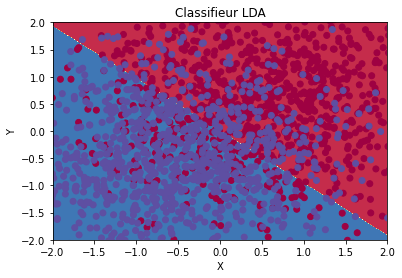

In [201]:
x_min,x_max = X_train[:,0].min()-0.5 ,X_train[:,0].max() + 0.5
y_min,y_max = X_train[:,1].min()-0.5 ,X_train[:,1].max() + 0.5

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = lda.predict(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)

plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(xmax=2,xmin=-2)
plt.ylim(ymax=2,ymin=-2)
plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Spectral)
plt.title("Classifieur LDA")
plt.show()

## Test

1. On fait des test sur les algos en variant la dimension de x

In [245]:
class Test:
    def __init__(self,p_label_0 = 0.5,n_apprentissage=3000,n_test=300,mean_0=0.5,mean_1 = -0.5):
        self.p_label_0 = p_label_0
        self.n_apprentissage = n_apprentissage
        self.n_test = n_test
        self.mean_0 = mean_0
        self.mean_1 = mean_1

    def __pretrain(self,dim = 2):
        self.d = dim
        n_label0 = int(self.n_apprentissage * self.p_label_0)
        n_label1 = int(self.n_apprentissage * (1-self.p_label_0))
        self.mean_0 = np.ones(dim)*0.5
        self.mean_1 = np.ones(dim) * -0.5
        self.cov_0 = np.ones(dim)
        self.cov_1 = np.ones(dim)
        res0 = multivariate_normal.rvs(mean=self.mean_0,cov=self.cov_0,size=n_label0)
        res1 = multivariate_normal.rvs(mean=self.mean_1,cov=self.cov_1,size=n_label1)

        X0 = np.array(res0)
        X1 = np.array(res1)
        label0 = np.zeros(shape=(len(res0),1))
        label1 = np.ones(shape=(len(res1),1))

        X_train = np.concatenate([X0,X1],0)
        Y_train = np.concatenate([label0,label1],0)

        self.bayes = Bayesien(n_label0,n_label1,self.mean_0,self.mean_1)
        self.knn = KNN()
        self.knn.train(X_train,Y_train)
        self.lda = LDA()
        self.lda.train(X_train,Y_train)

    def error(self,dim):
        self.__pretrain(dim = dim)
        x0 = multivariate_normal.rvs(mean=self.mean_0,cov=self.cov_0,size=int(self.n_test*self.p_label_0))
        x1 = multivariate_normal.rvs(mean=self.mean_1,cov=self.cov_1,size=int(self.n_test*(1-self.p_label_0)))
        label0 = np.zeros(shape=(len(x0),1))
        label1 = np.ones(shape=(len(x1),1))

        X_test = np.concatenate([x0,x1],axis = 0)
        Y_test = np.concatenate([label0,label1],axis=0).reshape(self.n_test,)
        prediction_bayes = self.bayes.predict(X_test)
        prediction_knn = self.knn.predict(X_test)
        prediction_lda = self.lda.predict(X_test)

        erreur_bayes = np.sum(np.abs(prediction_bayes - Y_test))/self.n_test
        erreur_knn = np.sum(np.abs(prediction_knn - Y_test))/self.n_test
        erreur_lda = np.sum(np.abs(prediction_lda - Y_test))/self.n_test
        return erreur_bayes,erreur_knn,erreur_lda



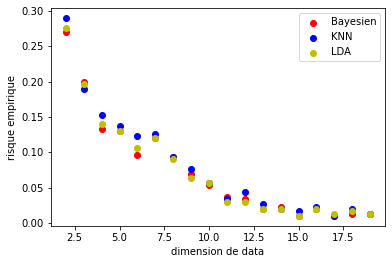

In [246]:
test = Test()

ds = np.arange(2,20)
e_b = np.zeros(ds.shape)
e_k = np.zeros(ds.shape)
e_l = np.zeros(ds.shape)
for i in range(len(ds)):
    e_b[i],e_k[i],e_l[i] = test.error(ds[i])
fig = plt.figure()
plt.scatter(ds,e_b,c = 'r',label = 'Bayesien')
plt.scatter(ds,e_k,c = 'b',label = 'KNN')
plt.scatter(ds,e_l,c = 'y',label = 'LDA')
plt.xlabel('dimension de data')
plt.ylabel('risque empirique')
plt.legend()
plt.show()